# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np

# Convolutional Layers
## Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

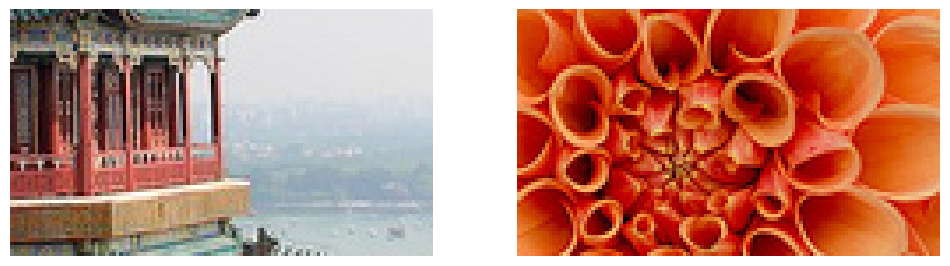

In [ ]:
# Display the two images

plt.figure(figsize=(12, 8))
for image_idx in (0, 1):
  plt.subplot(1, 2, image_idx + 1)
  plt.imshow(images[image_idx, :, :, :], cmap="gray")
  plt.axis("off")

plt.show()

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

**Task 1:** Explain the 4 values in the shape printed above (i.e. what does 2 correspond to? what does 64 correspond to, etc).

**Answer 1:** Put your answer here

2 = indicates there are two images in the batch.

70 = corresponds to the height of the images.

120 = corresponds to the width of the images.

3 = represents the number of color channels, which here implies the images are in RGB color space





Now, we will define a convollutional layer and pass these images through the layer and check the output. When you create the convolutional layer, it will simply create random filters (i.e. random numbers in the filter matrix)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

**Task 2:** Explain the 4 values in the shape printed above (i.e. what does 2 correspond to? what does 64 correspond to, etc). Explain the size change in the image.

**Answer 2:** Put your answer here

2 = indicates there are still two images in the batch.

64 = corresponds to the new height of the images after the convolution.

114 = corresponds to the new width of the images after the convolution.

32 = represents the number of feature maps (filters applied).


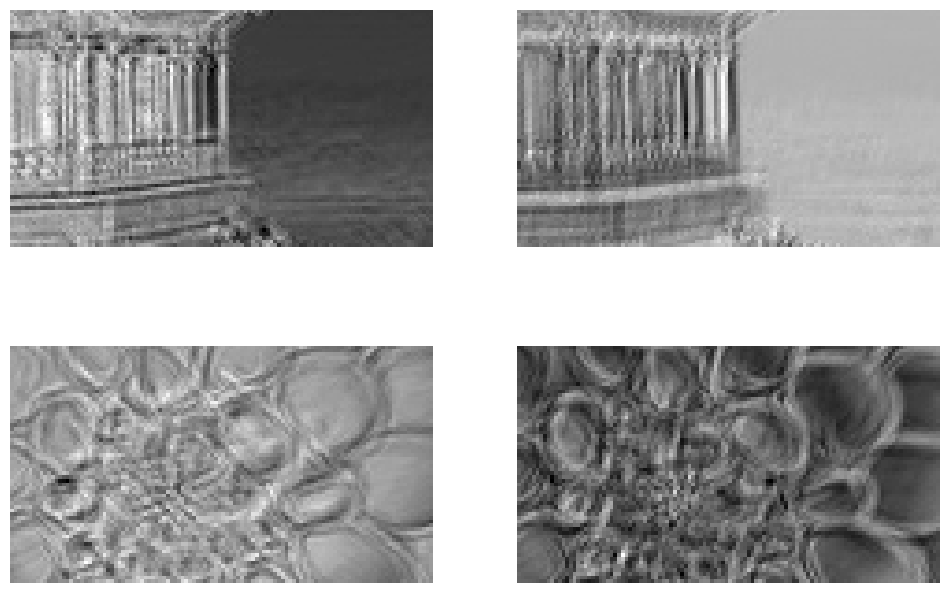

In [ ]:
# Display the two output feature maps for each image
# There are a total of 32, we just dsiplay 2 of those
plt.figure(figsize=(12, 8))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding for the convolution operation:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

Note that this time, the output image shapes are the same as the input image shapes

Now we will experiment with the strides parameter. Check out the output shape when strides is set to 2.

In [ ]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# Here is a utility function that can be useful to compute the size of the
#  feature maps output by a convolutional layer. It also returns
#  the number of ignored rows or columns if padding="valid", or the
#  number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

**Task 3:** Explain the 4 values in the shape printed above. What is the total number of weights in the kernels variable?

**Answer 3:** Put your answer here


The first two values (7, 7) are the height and width of the filter kernels.

The third value (3) is the number of input channels the filter is working with, matching the depth of the input images (RGB, hence 3).

The fourth value (32) is the number of filters, which corresponds to the number of output channels the layer will produce.

To find the total number of weights, you multiply all these values together:

**Total weights = 7×7×3×32 = 4,704**

Let's also check the shape of biases

In [ ]:
biases.shape

(32,)

# Pooling Layers
## Implementing Pooling Layers With Keras

**Max pooling**

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)
print('Output size = ', output.shape)

Output size =  (2, 35, 60, 3)


**Task 4:** Explain the size changes with the pooling layer above.

**Answer 4:** Put your answer here


The pool_size=2 slides a 2x2 window over the image. In each window, the maximum value is taken and forms a new, smaller image. This operation divide be half the height and width because it takes the largest value from each 2x2 area and skips every other pixel due to the stride being equal to pool size. The depth remains the same because pooling is applied separately to each depth slice.

Here, the original shape of the image batch (70, 120, 3) becomes (35, 60, 3) after max pooling, maintaining two images in the batch, with reduced height and width, but the same depth.

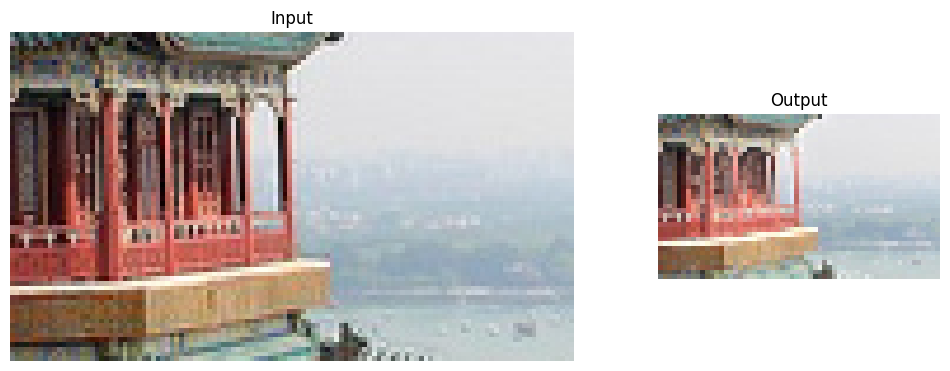

In [ ]:
# This cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [ ]:
# Let's load the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

# Adding number of layers in image as the last dimension in matrices
# This is required for convolutional layers in the CNN
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print('X_train.shape, X_valid.shape, X_test.shape:')
print(X_train.shape, X_valid.shape, X_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
X_train.shape, X_valid.shape, X_test.shape:
(55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


**CNN Model definition**

In [ ]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 256)        

Let's train this network and evaluate it on the test set

In [ ]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
print('Loss and accuracy on the test set:', score)

Epoch 1/5
1719/1719 [==============================] - 29s 9ms/step - loss: 0.7301 - accuracy: 0.7458 - val_loss: 0.3433 - val_accuracy: 0.8702
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4103 - accuracy: 0.8605 - val_loss: 0.3181 - val_accuracy: 0.8828
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3511 - accuracy: 0.8819 - val_loss: 0.2759 - val_accuracy: 0.8968
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3112 - accuracy: 0.8960 - val_loss: 0.2483 - val_accuracy: 0.9020
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.8928
Loss and accuracy on the test set: [0.29394879937171936, 0.892799973487854]


**Task 5:** Use the model definition in this example, name it as model2 and re-run the tests (use the same training parameters as the test above). https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

Compare the two models (the one we have just trained and the new model from this Kaggle notebook) interms of total number of trainable parameters and the accuracies on test data. Which model is better?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# Answer 5a: Put your code here (you can add more cells)
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
print('Loss and accuracy on the test set:', score)



Epoch 1/5
1719/1719 [==============================] - 20s 9ms/step - loss: 0.4757 - accuracy: 0.8290 - val_loss: 0.3072 - val_accuracy: 0.8780
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3177 - accuracy: 0.8835 - val_loss: 0.2694 - val_accuracy: 0.8970
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2768 - accuracy: 0.8981 - val_loss: 0.2443 - val_accuracy: 0.9066
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2546 - accuracy: 0.9064 - val_loss: 0.2283 - val_accuracy: 0.9148
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2289 - accuracy: 0.9174
Loss and accuracy on the test set: [0.22894133627414703, 0.9174000024795532]


**Answer 5b:** Type your answer here

Model2 had a better accuracy and lower loss showing that was a better model.

Model2 LESS PARAMETERS (HALF) AND MORE ACCURACY SO IT IS INDEED BETTER!


**! Do not forget to save your notebook, download your ipynb file and upload it in forum.**